In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
from qlstm_pennylane import QLSTM


# preprocessing

In [43]:
df_half_hour=pd.read_csv('completed data.csv')
df_half_hour.isna().sum()

station       0
valid         0
lon           0
lat           0
elevation     0
relh          0
drct          0
sknt          0
alti          0
vsby          0
metar         0
temp_c        0
dewpoint_c    0
feel_c        0
dtype: int64

In [44]:
colums=['elevation','station','lon','lat','metar']
filter_df=df_half_hour.drop(columns=colums)
filter_df

,valid,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,1/1/2010 0:00,72.20,170.0,3.0,30.09,3.73,16.0,11.0,16.0
1,1/1/2010 0:30,72.20,170.0,3.0,30.09,1.86,16.0,11.0,16.0
2,1/1/2010 1:00,72.20,150.0,4.0,30.09,1.24,16.0,11.0,16.0
3,1/1/2010 1:30,72.20,150.0,4.0,30.09,1.24,16.0,11.0,16.0
4,1/1/2010 2:00,76.98,150.0,8.0,30.09,1.24,15.0,11.0,15.0
...,...,...,...,...,...,...,...,...,...
260713,10/21/2024 21:30,56.63,50.0,8.0,30.09,6.21,22.0,13.0,22.0
260714,10/21/2024 22:00,56.63,40.0,10.0,30.09,6.21,22.0,13.0,22.0
260715,10/21/2024 22:30,56.63,40.0,7.0,30.12,6.21,21.0,13.0,22.0
260716,10/21/2024 23:00,60.21,30.0,7.0,30.09,6.21,21.0,13.0,21.0


In [45]:
# Ensure the 'valid' column is in datetime format
filter_df['valid'] = pd.to_datetime(filter_df['valid'])

# Add a 'date' column for easier grouping
filter_df['date'] = filter_df['valid'].dt.date

# Find rows with the maximum temperature for each day
daily_max_temp = filter_df.loc[filter_df.groupby('date')['temp_c'].idxmax()].reset_index(drop=True)

# Inspect the result
daily_max_temp.drop(columns=['valid'],inplace=True)
daily_max_temp


,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c,date
0,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000,2010-01-01
1,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889,2010-01-02
2,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000,2010-01-03
3,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000,2010-01-04
4,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000,2010-01-05
...,...,...,...,...,...,...,...,...,...
5402,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444,2024-10-17
5403,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444,2024-10-18
5404,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889,2024-10-19
5405,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333,2024-10-20


In [46]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 36.0


,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c,date
0,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000,2010-01-01
1,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889,2010-01-02
2,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000,2010-01-03
3,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000,2010-01-04
4,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000,2010-01-05
...,...,...,...,...,...,...,...,...,...
5402,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444,2024-10-17
5403,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444,2024-10-18
5404,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889,2024-10-19
5405,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333,2024-10-20


In [47]:
daily_max_temp=daily_max_temp.drop(columns=['date'])

# some functions needed

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Normalize data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Build and compile LSTM model
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(input_shape[-1]))  # Output neurons equal to feature count
    
    # Create the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model

# Function to plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()


def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = x_test[i].copy()
            
            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model.predict(sequence[np.newaxis, :, :])  # Add batch dimension
                prediction = prediction.reshape(1, n_features)  # Ensure correct shape
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for the current step
            final_prediction = model.predict(sequence[np.newaxis, :, :])
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict




# sequances lenth 1 and 1 qubit

In [8]:
data=daily_max_temp['temp_c'].values.reshape(-1,1)
data,scaler=normalize_data(data)

In [9]:
# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)
# Initialize variables
sequence_length =1

# Make a copy of the original DataFrame to update
updated_data = data.copy()

X, y = create_sequences(updated_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"data X train shape: {X_train.shape},data X test shape: {X_test.shape}")
print(f"data y train shape: {y_train.shape},data y test shape: {y_test.shape}")


data X train shape: (4324, 1, 1),data X test shape: (1082, 1, 1)
data y train shape: (4324, 1),data y test shape: (1082, 1)


In [14]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [15]:
# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0,n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits,n_qlayers=n_qlayers ,backend=backend)
        else:
            print("Using Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
        output = self.fc(lstm_out[:, -1])  # Predict next value
        return output

In [17]:
# Model parameters
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 1
backend = 'default.qubit'

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.1324
Epoch 20/300, Loss: 0.1314
Epoch 30/300, Loss: 0.1285
Epoch 40/300, Loss: 0.1183
Epoch 50/300, Loss: 0.0877
Epoch 60/300, Loss: 0.0364
Epoch 70/300, Loss: 0.0226
Epoch 80/300, Loss: 0.0217
Epoch 90/300, Loss: 0.0206
Epoch 100/300, Loss: 0.0202
Epoch 110/300, Loss: 0.0200
Epoch 120/300, Loss: 0.0199
Epoch 130/300, Loss: 0.0199
Epoch 140/300, Loss: 0.0199
Epoch 150/300, Loss: 0.0198
Epoch 160/300, Loss: 0.0198
Epoch 170/300, Loss: 0.0198
Epoch 180/300, Loss: 0.0198
Epoch 190/300, Loss: 0.0198
Epoch 200/300, Loss: 0.0198
Epoch 210/300, Loss: 0.0198
Epoch 220/300, Loss: 0.0198
Epoch 230/300, Loss: 0.0198
Epoch 240/300, Loss: 0.0198
Epoch 250/300, Loss: 0.0198
Epoch 260/300, Loss: 0.0198
Epoch 270/300, Loss: 0.0198
Epoch 280/300, Loss: 0.0198
Epoch 290/300, Loss: 0.0198
Epoch 300/300, Loss: 0.0198


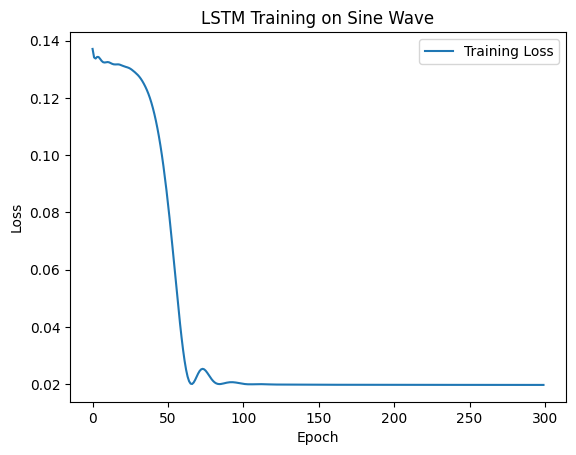

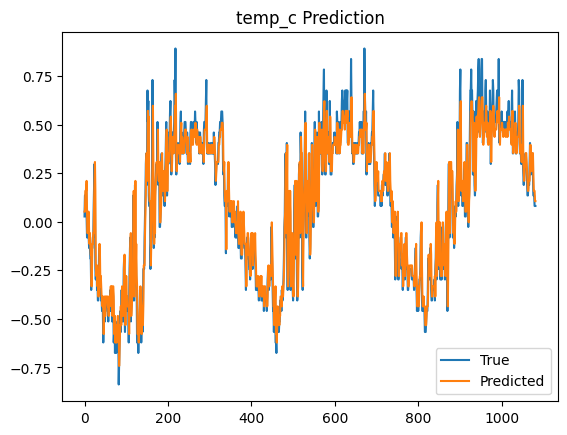

In [18]:
model = LSTMRegressor(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('temp_c Prediction')
plt.show()

Using Classical LSTM
Epoch 10/300, Loss: 0.0992
Epoch 20/300, Loss: 0.0541
Epoch 30/300, Loss: 0.0211
Epoch 40/300, Loss: 0.0246
Epoch 50/300, Loss: 0.0203
Epoch 60/300, Loss: 0.0208
Epoch 70/300, Loss: 0.0202
Epoch 80/300, Loss: 0.0202
Epoch 90/300, Loss: 0.0202
Epoch 100/300, Loss: 0.0201
Epoch 110/300, Loss: 0.0201
Epoch 120/300, Loss: 0.0201
Epoch 130/300, Loss: 0.0201
Epoch 140/300, Loss: 0.0201
Epoch 150/300, Loss: 0.0201
Epoch 160/300, Loss: 0.0201
Epoch 170/300, Loss: 0.0201
Epoch 180/300, Loss: 0.0201
Epoch 190/300, Loss: 0.0201
Epoch 200/300, Loss: 0.0201
Epoch 210/300, Loss: 0.0201
Epoch 220/300, Loss: 0.0201
Epoch 230/300, Loss: 0.0201
Epoch 240/300, Loss: 0.0201
Epoch 250/300, Loss: 0.0201
Epoch 260/300, Loss: 0.0200
Epoch 270/300, Loss: 0.0200
Epoch 280/300, Loss: 0.0200
Epoch 290/300, Loss: 0.0200
Epoch 300/300, Loss: 0.0200


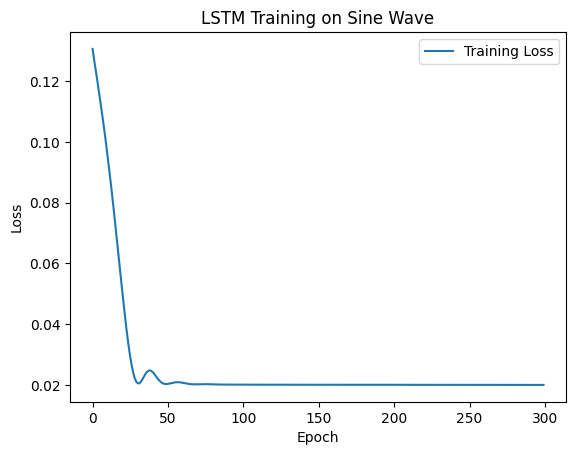

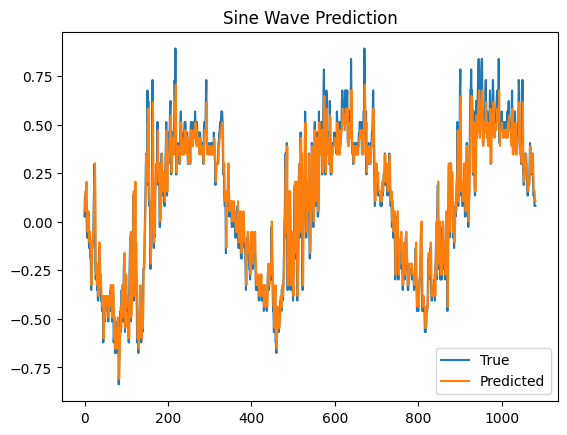

In [16]:
# Model parameters
Cinput_dim = 1
Chidden_dim = 16
backend = 'default.qubit'
model = LSTMRegressor(Cinput_dim, Chidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Prediction')
plt.show()

**mmm**

# 8 diminthion data sequances lenth 1 and 8 qubit

In [48]:
data = daily_max_temp.iloc[:, :8].values  # Extract first 8 columns as features
data

array([[ 41.42      , 200.        ,   4.        , ...,  25.        ,
         11.        ,  25.        ],
       [ 33.85      , 230.        ,  11.        , ...,  25.        ,
          8.        ,  24.43888889],
       [ 53.03      , 280.        ,   4.        , ...,  22.        ,
         12.        ,  22.        ],
       ...,
       [ 39.58      ,  30.        ,   9.        , ...,  28.        ,
         13.        ,  27.63888889],
       [ 34.69      ,  40.        ,  18.        , ...,  28.        ,
         11.        ,  27.33333333],
       [ 37.07      ,  30.        ,  14.        , ...,  28.        ,
         12.        ,  27.47777778]])

In [49]:
# Index of temp_c column
temp_c_index = daily_max_temp.columns.get_loc('temp_c')

# Normalize and create sequences
scaled_data, scaler = normalize_data(data)

# Define parameters
sequence_length = 1

# Create training data
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4324, 1, 8),data X test shape: (1082, 1, 8)
data y train shape: (4324, 8),data y test shape: (1082, 8)


In [57]:
X_train_tensor[:, :, temp_c_index]

tensor([[-0.0811],
        [-0.0811],
        [-0.2432],
        ...,
        [ 0.1892],
        [ 0.0270],
        [ 0.1351]])

In [30]:
# LSTMRegressor class with integrated classical LSTM
class LSTMRegressor_8_dim(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            # Use the build_lstm_model function to create the classical LSTM
            self.model, self.optimizer, self.criterion = build_lstm_model(input_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        if hasattr(self, 'model'):
            # Use the classical LSTM model
            return self.model(x)
        else:
            # Use the quantum LSTM
            lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
            output = self.fc(lstm_out[:, -1])  # Predict next values for all features
            return output

In [40]:
X_train_tensor

tensor([[[-0.2066,  0.1111, -0.9208,  ..., -0.0811,  0.2632,  0.0087]],

        [[-0.3625,  0.2778, -0.7822,  ..., -0.0811,  0.1053, -0.0196]],

        [[ 0.0325,  0.5556, -0.9208,  ..., -0.2432,  0.3158, -0.1427]],

        ...,

        [[-0.5738,  0.2222, -0.6832,  ...,  0.1892,  0.0526,  0.1789]],

        [[-0.2503,  0.6667, -0.9010,  ...,  0.0270,  0.3158,  0.1010]],

        [[-0.3394, -0.9444, -0.8614,  ...,  0.1351,  0.3158,  0.1702]]])

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 10/300 Train Loss: 0.1290 | Val Loss: 0.1294 Train R²: 0.0230 | Val R²: 0.0282
Epoch 20/300 Train Loss: 0.1020 | Val Loss: 0.0986 Train R²: 0.2273 | Val R²: 0.2594
Epoch 30/300 Train Loss: 0.0347 | Val Loss: 0.0278 Train R²: 0.7373 | Val R²: 0.7910
Epoch 40/300 Train Loss: 0.0259 | Val Loss: 0.0189 Train R²: 0.8041 | Val R²: 0.8580
Epoch 50/300 Train Loss: 0.0226 | Val Loss: 0.0190 Train R²: 0.8290 | Val R²: 0.8575
Epoch 60/300 Train Loss: 0.0202 | Val Loss: 0.0160 Train R²: 0.8470 | Val R²: 0.8801
Epoch 70/300 Train Loss: 0.0192 | Val Loss: 0.0157 Train R²: 0.8543 | Val R²: 0.8821
Epoch 80/300 Train Loss: 0.0188 | Val Loss: 0.0151 Train R²: 0.8577 | Val R²: 0.8866
Epoch 90/300 Train Loss: 0.0185 | Val Loss: 0.0149 Train R²: 0.8603 | Val R²: 0.8883
Epoch 100/300 Train Loss: 0.0182 | Val Loss: 0.0146 Train R²: 0.8623 | Val R²: 0.8903
Epoch 110/300 Train Loss: 0.0179 | Val Loss: 0.0144 Train 

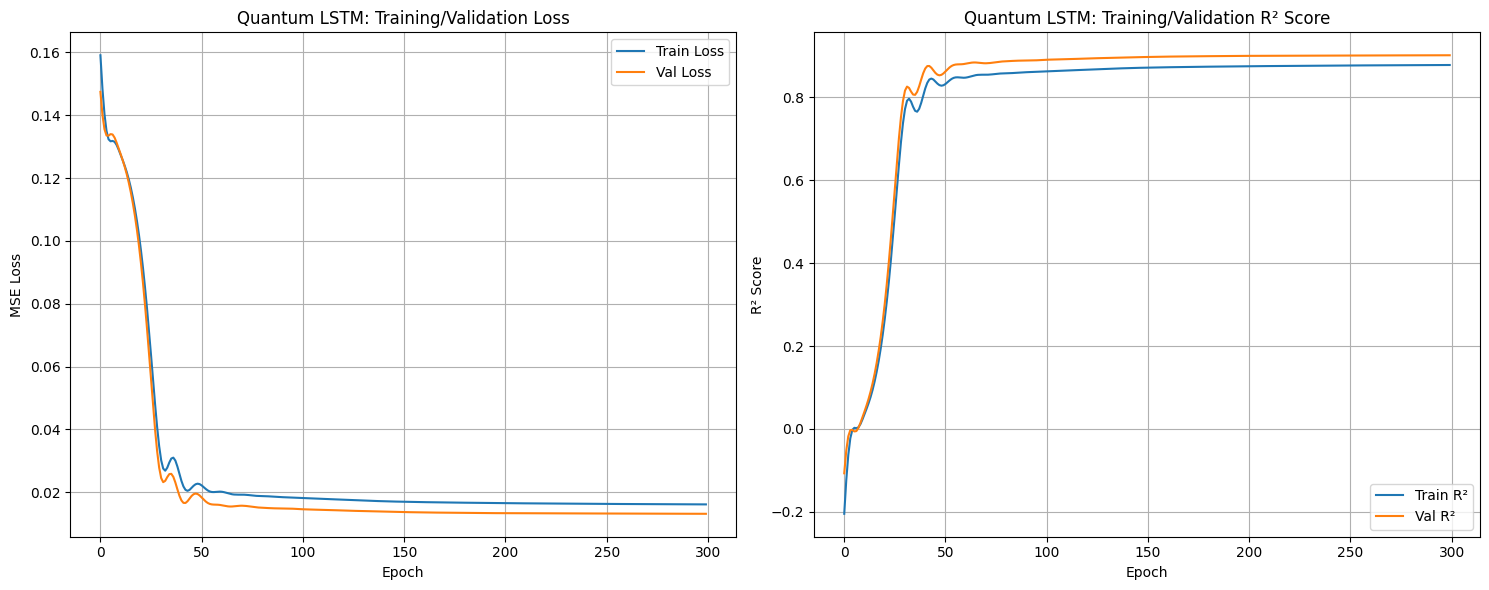

In [63]:
from sklearn.metrics import r2_score

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'
model = LSTMRegressor(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, 
                     n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs[:,temp_c_index], y_train_tensor[:,temp_c_index])
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np[:,temp_c_index], train_preds[:,temp_c_index], multioutput='uniform_average')
    
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs[:,temp_c_index], y_test_tensor[:,temp_c_index])
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np[:,temp_c_index], val_preds[:,temp_c_index], multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

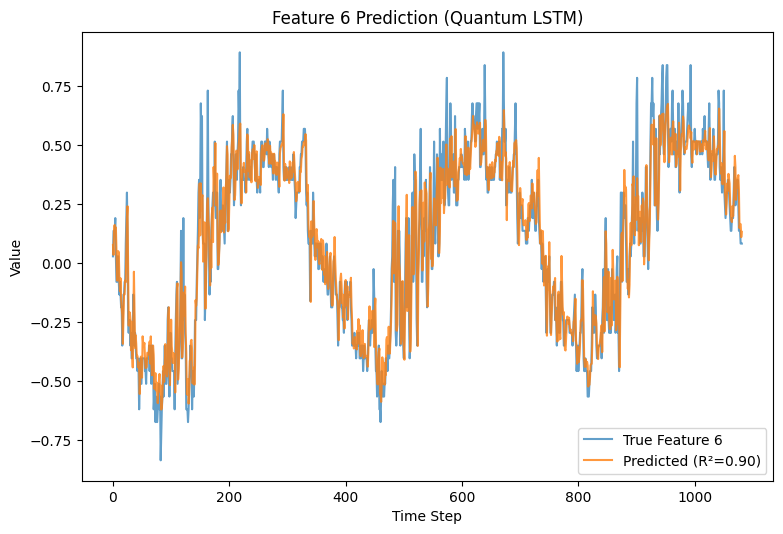


Quantum LSTM - Final Feature-wise Performance:
Feature 6: R² = 0.9013


In [65]:
# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    if i != temp_c_index:
        continue
    else:
        plt.subplot(4, 2, i+1)
        plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
        plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
        plt.title(f'Feature {i+1} Prediction (Quantum LSTM)')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    if i != temp_c_index:
        continue
    else:
        print(f"Feature {i+1}: R² = {r2:.4f}")

In [66]:
# Function to calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example: Assuming `model` is your PyTorch model
num_parameters = count_parameters(model)

print(f"The model has {num_parameters} trainable parameters.")

The model has 880 trainable parameters.


In [71]:
import numpy as np
import torch

def iterative_forecast_map(model, x_test, days_to_predict, scaler, device="cpu"):
    if isinstance(x_test, torch.Tensor):  # Ensure x_test is a NumPy array
        x_test = x_test.to(device).detach().numpy()

    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = torch.tensor(x_test[i], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dim

            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model(sequence)  # Forward pass instead of predict()
                prediction = prediction.squeeze(0).detach().cpu().numpy()  # Convert back to NumPy
                sequence = np.vstack((sequence.squeeze(0).cpu().numpy()[1:], prediction))  # Update sequence
                sequence = torch.tensor(sequence, dtype=torch.float32, device=device).unsqueeze(0)  # Convert back

            # Final prediction for the current step
            final_prediction = model(sequence).detach().cpu().numpy()
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move model to the correct device
predictions = iterative_forecast_map(model, X_test_tensor, 4, scaler, device=device)


In [ ]:
import numpy as np
import torch

def optimize_iterative_forecast_map(model, x_test, days_to_predict, scaler, device="cpu"):
    """Performs iterative multi-step forecasting efficiently using NumPy and PyTorch."""
    
    if isinstance(x_test, torch.Tensor):  # Convert PyTorch tensor to NumPy
        x_test = x_test.to(device).detach().cpu().numpy()

    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    # Preallocate array for predictions
    predicted_sequences = np.zeros((n_samples, seq_len + days_to_predict, n_features))
    predicted_sequences[:, :seq_len, :] = x_test  # Initialize with test data

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        for step in range(1, days_to_predict + 1):
            # Extract current sequences for prediction
            current_sequences = predicted_sequences[:, step - 1: step - 1 + seq_len, :]
            current_sequences_tensor = torch.tensor(current_sequences, dtype=torch.float32, device=device)

            # Predict next step
            next_predictions = model(current_sequences_tensor).cpu().numpy()

            # Ensure shape is (n_samples, 1, n_features)
            next_predictions = next_predictions.reshape(n_samples, 1, n_features)

            # Store predictions
            predicted_sequences[:, seq_len + step - 1, :] = next_predictions[:, 0, :]

            # Save results after inverse transformation
            prediction_dict[step] = scaler.inverse_transform(next_predictions[:, 0, :])

    return prediction_dict


In [79]:
optimize_predictions = optimize_iterative_forecast_map(model, X_test_tensor, 10, scaler, device=device)
optimize_predictions

{1: array([[ 59.184937 , 186.15178  ,  58.330116 , ...,  27.892296 ,
           4.6343164,  21.425512 ],
        [ 59.372364 , 185.85155  ,  57.864693 , ...,  27.109068 ,
           4.6108794,  21.508104 ],
        [ 59.30021  , 186.83836  ,  58.578884 , ...,  29.35098  ,
           4.6421304,  21.271399 ],
        ...,
        [ 59.29559  , 186.9478   ,  58.69449  , ...,  29.517906 ,
           4.661052 ,  21.23213  ],
        [ 59.217445 , 186.20274  ,  58.561413 , ...,  28.50093  ,
           4.65664  ,  21.333927 ],
        [ 59.068832 , 186.626    ,  58.72957  , ...,  28.926558 ,
           4.6328516,  21.328169 ]], dtype=float32),
 2: array([[ 59.037243 , 181.53111  ,  56.369686 , ...,  18.21162  ,
           4.400835 ,  22.393345 ],
        [ 59.04192  , 181.48058  ,  56.34583  , ...,  18.073921 ,
           4.400527 ,  22.403954 ],
        [ 59.02931  , 181.63232  ,  56.41455  , ...,  18.47568  ,
           4.4019785,  22.373287 ],
        ...,
        [ 59.02839  , 181.64542  

In [73]:
predictions

{1: array([[[ 59.184937 , 186.15178  ,  58.330116 , ...,  27.892292 ,
            4.6343164,  21.425512 ]],
 
        [[ 59.372364 , 185.85155  ,  57.864693 , ...,  27.109068 ,
            4.6108794,  21.508104 ]],
 
        [[ 59.30021  , 186.83836  ,  58.57888  , ...,  29.35098  ,
            4.6421304,  21.271399 ]],
 
        ...,
 
        [[ 59.29559  , 186.9478   ,  58.69449  , ...,  29.517906 ,
            4.661052 ,  21.232126 ]],
 
        [[ 59.217445 , 186.20274  ,  58.561413 , ...,  28.500933 ,
            4.6566405,  21.333927 ]],
 
        [[ 59.068832 , 186.626    ,  58.72957  , ...,  28.926558 ,
            4.6328516,  21.328169 ]]], dtype=float32),
 2: array([[[ 59.037243 , 181.53111  ,  56.369686 , ...,  18.21162  ,
            4.400835 ,  22.393345 ]],
 
        [[ 59.04192  , 181.48058  ,  56.34583  , ...,  18.073923 ,
            4.400527 ,  22.403954 ]],
 
        [[ 59.02931  , 181.63232  ,  56.41455  , ...,  18.47568  ,
            4.4019785,  22.373287 ]],
 
 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Function to classify each day based on specified criteria
def classify_heatwave(data, threshold):
    heatwave = [0] * len(data)  # Initialize the heatwave list with zeros
    for i in range(2, len(data)):
        if data[i] >= threshold:
            if data[i-1] >= threshold and data[i-2] >= threshold:
                heatwave[i] = 1
                heatwave[i-1] = 1
                heatwave[i-2] = 1
            else:
                heatwave[i] = 0
        else:
            heatwave[i] = 0
    return heatwave

# Ensure heatwave_df is created correctly
threshold = np.percentile(daily_max_temp["temp_c"], 90)
y_test_rescaled_df=pd.DataFrame(y_test_rescaled)
# Apply the function to classify each day
heatwave_flags = classify_heatwave(y_test_rescaled_df[temp_c_index].values, threshold)
actual1_test = y_test_rescaled_df.copy()
actual1_test["day_included_heatwave"] = heatwave_flags
predictions_rescaled_df=pd.DataFrame(predictions_rescaled)
# Apply the function to classify each day
heatwave_flags = classify_heatwave(predictions_rescaled_df[temp_c_index].values, threshold)
# Create a DataFrame with the classification results
predctions_comp_test = predictions_rescaled_df.copy()
predctions_comp_test["day_included_heatwave"] = heatwave_flags


print(len(actual1_test))
print(len(predctions_comp_test))

# Extract heatwave columns
y_true = actual1_test['day_included_heatwave']
y_pred = predctions_comp_test['day_included_heatwave']

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heatwave', 'Heatwave'], yticklabels=['No Heatwave', 'Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate precision, recall, accuracy, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



NameError: name 'y_test_rescaled' is not defined